# Rhythm model

In [1]:
"""
Rhythm processing model
"""

%matplotlib inline

from __future__ import division

from time import time
import sys
sys.path.append('../')  # needed to run the examples from within the package folder

import numpy as np
from scipy.signal import hilbert


from scipy.io import loadmat

from pygrfnn.network import Model, make_connections, modelFromJSON
from pygrfnn.oscillator import Zparam
from pygrfnn.grfnn import GrFNN
from pygrfnn import MPL

if MPL:
    import matplotlib.pyplot as plt
    from pygrfnn.vis import plot_connections
    from pygrfnn.vis import tf_detail
    from pygrfnn.vis import GrFNN_RT_plot

from pyrhythm.library import get_pattern
from daspy import Signal
from daspy.processing import onset_detection_signal

RT_display = False

def get_stimulus(pattern_name="iso",
                 tempo=120.0,
                 reps=6.0,
                 lead_silence=0.0,
                 sr=16000.0,
                 click_freq=1200.0,
                 with_beat=False,
                 beat_freq=1800.0,
                 accented=False,
                 win_len=2048, 
                 hop_size=512, 
                 mel_bands=64
                 ):
    p = get_pattern(pattern_name)
    x, _ = p.as_signal(tempo=tempo,
                     reps=reps,
                     lead_silence=lead_silence,
                     sr=sr,
                     click_freq=click_freq,
                     with_beat=with_beat,
                     beat_freq=beat_freq,
                     accented=accented)
    x = Signal(x, sr=sr)
    s = onset_detection_signal(x, win_len=win_len, hop_size=hop_size, mel_bands=mel_bands)

    rms = np.sqrt(np.sum(s**2)/len(s))
    s *= 0.06/rms
    s = Signal(hilbert(s), sr=s.sr)
    t = s.time_vector()
    dt = 1/s.sr
    # print "SR: ", s.sr
    return s, t, dt

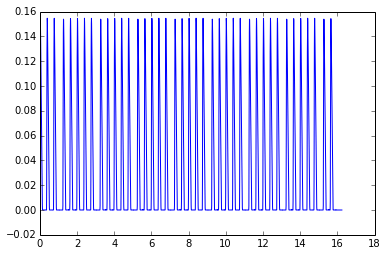

In [16]:
pattern_name = "bossa"

s, t, dt = get_stimulus(pattern_name,
                        tempo=120.0,
                        reps=8,
                        hop_size=128,
                        win_len=2048*2,
                       )

plt.figure()
plt.plot(t, s)

In [19]:
def rhythm_model():
    rhythm_model_definition = {
        "name": "Sensory Motor Rhythm model",
        "layers": [
            {
                "name": "sensory network",
                "zparams": {
                    "alpha": 0.00001,
                    "beta1": -2.0,
                    "beta2": -2.0,
                    "delta1": 0.0,
                    "delta2": 0.0,
                    "epsilon": 1.0
                },
                "frequency_range": [0.375, 12.0],
                "num_oscs": 320,
                "stimulus_conn_type": "allfreq",
                "input_channel": 0
            },
            {
                "name": "motor network",
                "zparams": {
                    "alpha": -0.4,
                    "beta1": 1.75,
                    "beta2": -1.25,
                    "delta1": 0.0,
                    "delta2": 0.0,
                    "epsilon": 1.0
                },
                "frequency_range": [0.375, 12.0],
                "num_oscs": 321,
                "stimulus_conn_type": "active"
            }
        ],
        "connections": [
            {
                "source_name": "sensory network",
                "target_name": "sensory network",
                "modes": [0.333333333333, 0.5, 1, 2.0, 3.0],
                "amps": [1, 1, 1, 1, 1],
                "strength": 1.0,
                "range": 1.05,
                "connection_type": "2freq",
                "self_connect": False,
                "weight": 0.25
            },
            {
                "source_name": "sensory network",
                "target_name": "motor network",
#                 "modes": [0.333333333333, 0.5, 1, 2.0, 3.0],
#                 "amps": [1, 1, 1, 1, 1],
                "modes": [1.0],
                "amps": [1.0],
                "strength": 1.25,
                "range": 1.05,
                "connection_type": "2freq",
                "self_connect": True,
                "weight": 0.4
            },
#             {
#                 "source_name": "motor network",
#                 "target_name": "motor network",
#                 "modes": [0.333333333333, 0.5, 1, 2.0, 3.0],
#                 "amps": [1, 1, 1, 1, 1],
#                 "strength": 1.0,
#                 "range": 1.05,
#                 "connection_type": "2freq",
#                 "self_connect": False,
#                 "weight": 0.1
#             },
#             {
#                 "source_name": "motor network",
#                 "target_name": "sensory network",
#                 "modes": [0.333333333333, 0.5, 1, 2.0, 3.0],
#                 "amps": [1, 1, 1, 1, 1],
#                 "strength": 0.2,
#                 "range": 1.05,
#                 "connection_type": "2freq",
#                 "self_connect": True,
#                 "weight": 0.05
#             }
        ]
    }

    return modelFromJSON(rhythm_model_definition)

In [ ]:
gain = 0.25
model = rhythm_model()

tic = time()
model.run(gain*s, t, dt)
print "Run time: {:0.1f} seconds".format(time() - tic)

TF = model.layers()[-1].Z
f = model.layers()[-1].f

# 
plt.figure()
tf_detail(TF, t, f, t_detail=t[-1])


# mean field
r = np.sum(TF, 0)
rms = np.sqrt(np.sum(r*np.conj(r))/len(r))
r *= 0.06/rms
plt.figure()
plt.plot(t, np.real(r))
plt.plot(t, np.real(s))

0747/2031